In [2]:
import contractions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os
import re
import seaborn as sns
import spacy
import tensorflow as tf
import time
import unidecode

from bs4 import BeautifulSoup


from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import LSTM

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.python.keras.models import Sequential

from word2number import w2n

In [2]:
# funtion to write predictions
def write_preds(preds, fname):
    pd.DataFrame({"id": list(range(1,len(preds)+1)), "target":   preds}).to_csv(fname, index=False)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(len(train))
print(len(test))

7613
3263


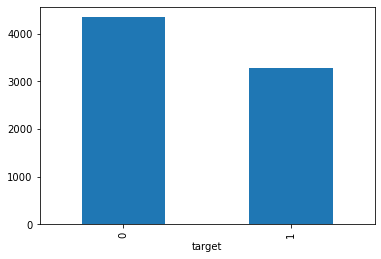

In [6]:
train.groupby('target').target.count().plot.bar(ylim=0)

In [7]:
train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [8]:
train.keyword.nunique()

221

(array([ 4.,  0.,  1.,  1.,  3., 18., 80., 70., 41.,  3.]),
 array([ 9. , 12.6, 16.2, 19.8, 23.4, 27. , 30.6, 34.2, 37.8, 41.4, 45. ]),
 <a list of 10 Patch objects>)

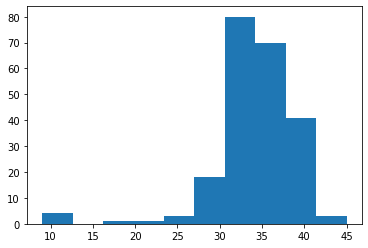

In [9]:
plt.hist(train.keyword.value_counts())

In [10]:
train.location.value_counts()

USA                         104
New York                     71
United States                50
London                       45
Canada                       29
                           ... 
PG Chillin!                   1
ÛÊÛÊÛÊ                     1
New Jersey                    1
Hamilton, Ontario Canada      1
Edmonton, Alberta             1
Name: location, Length: 3341, dtype: int64

In [11]:
train.location.nunique()

3341

## Text Processing

In [12]:
def clean_text(text):
    """ Cleaning function to remove unwanted features using regular expressions """
    # remove HTML
    cleaned_text = re.sub('<[^>]*>', '', text.lower())
    
    # remove punctuation and symbols
    cleaned_text = re.sub('[\W]+', ' ', cleaned_text)
    
    # remove urls
    cleaned_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', cleaned_text)
    
    # remove emojis
    emojis = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emojis
                        u"\U0001F300-\U0001F5FF"  # symbols / pictographs
                        u"\U0001F680-\U0001F6FF"  # transport / map symbols
                        u"\U0001F1E0-\U0001F1FF"  # iOS flags
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251]+", flags=re.UNICODE)
    cleaned_text = emojis.sub(r'', cleaned_text)
    
    return cleaned_text

In [13]:
def split_and_stem(text, stem_text=True, lemmatize_text=False):
    """ Form tokenised stemmed text using a list comp and return """
    if lemmatize_text:
        tokenised = [lemmatizer.lemmatize(word) for word in text.split()]
    elif stem_text:
        tokenised = [porter.stem(word) for word in text.split()]
    else:
        tokenised = [word for word in text.split()]
    return tokenised

In [14]:
def remove_stopwords(text, stem_text=True, lemmatize_text=False):
    """ Remove stopwords from the text after split and stemming """
    words = [word for word in split_and_stem(text, stem_text=stem_text, 
                                             lemmatize_text=lemmatize_text) if word not in sw]
    # remove 1 letter words
    words = [word for word in words if len(word) > 1]
    new_text = " ".join(words)
    return new_text

In [15]:
def preprocess_text(text, stopwords=True, stem=True, lemmatize=False):
    """ Preprocess text through cleaning, stemming and stop-word removal """
    tokenised = clean_text(text)
    if stopwords:
        tokenised = remove_stopwords(tokenised, stem_text=stem, lemmatize_text=lemmatize)
    return tokenised

In [16]:
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# stop words - add additionals
sw = stopwords.words('english')
sw.append('http')
sw.append('https')
sw.append('co')
sw.append('û_')

In [17]:
start = time.time()
train['cleaned text'] = train['text'].apply(preprocess_text, stopwords=True,stem=False, lemmatize=False)
end = time.time()
print("Processing took {:.2f}s".format(end - start))

Processing took 1.02s


In [18]:
test['cleaned text'] = test['text'].apply(preprocess_text, stopwords=True,stem=False, lemmatize=False)

In [19]:
X = train['cleaned text'].values
test_X = test['cleaned text'].values
y = train['target'].values

In [20]:
max_words = 10000
max_length = 100

tokeniser = Tokenizer(num_words=max_words)
tokeniser.fit_on_texts(X)
seqs = tokeniser.texts_to_sequences(X)
test_seqs = tokeniser.texts_to_sequences(test_X)

word_index = tokeniser.word_index
vocabulary_size = len(word_index) + 1

In [21]:
X = sequence.pad_sequences(seqs, maxlen=max_length)
test_X = sequence.pad_sequences(test_seqs, maxlen=max_length)

In [22]:
 # Final training dataset to feed into LSTM model.
X.shape

(7613, 100)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 60,shuffle=True)

print(len(X_train))
print(len(X_test))

6090
1523


## Model 1

In [35]:
def create_RNN_model():
    model = Sequential()
    
    model.add(Embedding(vocabulary_size, 32, input_length=max_length))
    model.add(LSTM(32, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [36]:
model1 = create_RNN_model()

In [37]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           1378048   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,415,297
Trainable params: 1,415,297
Non-trainable params: 0
_________________________________________________________________


In [38]:
start = time.time()
modelfit1 = model1.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
end = time.time()
print("Training took {:.2f}s".format(end - start))

Epoch 1/10
48/48 [==============================] - 10s 198ms/step - loss: 0.6643 - accuracy: 0.6007 - val_loss: 0.6087 - val_accuracy: 0.7242
Epoch 2/10
48/48 [==============================] - 8s 169ms/step - loss: 0.4558 - accuracy: 0.8011 - val_loss: 0.4668 - val_accuracy: 0.7965
Epoch 3/10
48/48 [==============================] - 8s 170ms/step - loss: 0.2878 - accuracy: 0.8844 - val_loss: 0.5016 - val_accuracy: 0.7866
Epoch 4/10
48/48 [==============================] - 8s 170ms/step - loss: 0.2203 - accuracy: 0.9163 - val_loss: 0.5410 - val_accuracy: 0.7735
Epoch 5/10
48/48 [==============================] - 8s 168ms/step - loss: 0.1678 - accuracy: 0.9383 - val_loss: 0.6659 - val_accuracy: 0.7708
Epoch 6/10
48/48 [==============================] - 8s 169ms/step - loss: 0.1377 - accuracy: 0.9509 - val_loss: 0.7283 - val_accuracy: 0.7643
Epoch 7/10
48/48 [==============================] - 8s 170ms/step - loss: 0.1194 - accuracy: 0.9562 - val_loss: 0.7136 - val_accuracy: 0.7603
Epoch

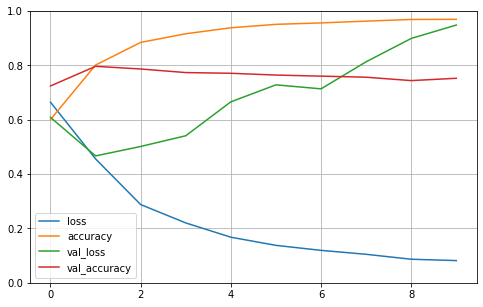

In [39]:
 # Learning curves: the mean training loss and accuracy measured over each epoch, and the mean validation loss and 
# accuracy measured at the end of each epoch
pd.DataFrame(modelfit1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [40]:
model1.evaluate(X_test, y_test)

48/48 [==============================] - 1s 25ms/step - loss: 0.9483 - accuracy: 0.7525


[0.9483200907707214, 0.7524622678756714]

In [41]:
#create 1D array of y_test for validation
y_true = y_test

In [42]:
y_pred1 = model1.predict(X_test)
y_pred1_classes = np.argmax(y_pred1, axis=1)

In [43]:
report1 = classification_report(y_true, y_pred1_classes, output_dict=True)
result1 = pd.DataFrame(report1).transpose()
result1

C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.581747,1.000000,0.735575,886.000000
1,0.000000,0.000000,0.000000,637.000000
accuracy,0.581747,0.581747,0.581747,0.581747
macro avg,0.290873,0.500000,0.367787,1523.000000
weighted avg,0.338429,0.581747,0.427918,1523.000000


In [49]:
submission1 = (model1.predict(test_X) >0.5).astype("int32")

In [126]:
result_df = pd.DataFrame(columns=['id', 'target'])
result_df.id = sample.id
result_df.target = submission1

In [132]:
result_df.to_csv('LSTM1.csv', index=False)

#### KaggleID: JThomas2020 Score: 0.76279

This model performed fairly well considering the unstructured nature of human tweets. This equates to approximately 3/4 tweets that indicate a disaster will be properly identified. Perhaps entering another LSTM layer will allow the model to remember information better. 

## Hyperparameter Tuning

In [93]:
K.clear_session()

In [94]:
INPUT_SHAPE = X.shape[1:]

In [95]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes           
            
    def build(self, hp):    
        model = Sequential()
        
        model.add(Embedding(vocabulary_size, 32, input_length=max_length))
        model.add(LSTM(32, return_sequences=True))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5,default=0.25)))
        model.add(LSTM(32, return_sequences=True))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.25)))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',min_value=1e-4,max_value=1e-2,sampling='LOG',
                    default=1e-3)),loss='binary_crossentropy',metrics=['accuracy'])
        return model

In [96]:
hypermodel = LSTMHyperModel(input_shape=vocabulary_size, num_classes=2)

In [97]:
tuner = Hyperband(
    hypermodel,
    max_epochs=20,
    objective='val_accuracy',
    directory= os.path.normpath('C:/james/Desktop/LSTM'))

INFO:tensorflow:Reloading Oracle from existing project C:\james\Desktop\LSTM\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from C:\james\Desktop\LSTM\untitled_project\tuner0.json


In [98]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
dropout_4 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
dropout_5 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [99]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 27 Complete [00h 11m 09s]
val_accuracy: 0.5986407995223999

Best val_accuracy So Far: 0.5990807414054871
Total elapsed time: 02h 07m 21s
INFO:tensorflow:Oracle triggered exit


In [100]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in C:\james\Desktop\LSTM\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.442913588871109
dropout_2: 0.15353406563758437
dropout_3: 0.13535233420591714
dropout_4: 0.34149973541600825
dropout_5: 0.14659598953545616
learning_rate: 0.0011695529042992335
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: ef8b17ab79d471d96dd7cc6bdc3f9337
Score: 0.5990807414054871
Trial summary
Hyperparameters:
dropout_1: 0.159614569892565
dropout_2: 0.33017478923209514
dropout_3: 0.31077923882206243
dropout_4: 0.46713446188038826
dropout_5: 0.11098578639329659
learning_rate: 0.0007425894066139745
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.5990545153617859
Trial summary
Hyperparameters:
dropout_1: 0.3976660428807479
dropout_2: 0.2753157755964308
dropout_3: 0.4723715316510392
dropout_4: 0.1221078440176887
dropout_5: 0.40529461592531

## Model 2

In [101]:
# Retrieve the best model.
best_model = tuner.get_best_models()[0]

In [102]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           689024    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           8320      
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
dense (Dense)                (None, 100, 1)            33        
Total params: 705,697
Trainable params: 705,697
Non-trainable params: 0
__________________________________________________

In [103]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)

48/48 [==============================] - 2s 33ms/step - loss: 0.6685 - accuracy: 0.5991


In [104]:
y_pred2 = best_model.predict(X_test)
y_pred2_classes = np.argmax(y_pred2, axis=1)

In [105]:
report2 = classification_report(y_true, y_pred2_classes, output_dict=True)
result2 = pd.DataFrame(report2).transpose() 
result2

C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.820513,0.686230,0.747388,886.000000
1,0.000000,0.000000,0.000000,637.000000
84,0.000000,0.000000,0.000000,0.000000
85,0.000000,0.000000,0.000000,0.000000
86,0.000000,0.000000,0.000000,0.000000
87,0.000000,0.000000,0.000000,0.000000
88,0.000000,0.000000,0.000000,0.000000
89,0.000000,0.000000,0.000000,0.000000
90,0.000000,0.000000,0.000000,0.000000
91,0.000000,0.000000,0.000000,0.000000


In [106]:
submission2 = (best_model.predict(test_X) >0.5).astype("int32")

In [113]:
submit2 = submission2[:,0,0]

In [114]:
submit2.shape

(3263,)

In [129]:
result_df2 = pd.DataFrame(columns=['id', 'target'])
result_df2.id = sample.id
result_df2.target = submit2

In [131]:
result_df2.to_csv('LSTM2.csv', index=False)

#### KaggleID: JThomas2020 Score: 0.57033

The hyperparameter model performed particularly worse. This is likely due to the flucuating dropout rates tested along with the small amount of epochs trained per parameter set. it's likely that a dropout rate between .2 and .3 is ideal with an epoch total of 15.

## Model 3

In [139]:
# Retrieve the 2nd best model from hyperparameter search.
best_model2 = tuner.get_best_models(num_models=3)[2]

In [140]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           689024    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           8320      
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
dense (Dense)                (None, 100, 1)            33        
Total params: 705,697
Trainable params: 705,697
Non-trainable params: 0
__________________________________________________

In [141]:
loss, accuracy = best_model2.evaluate(X_test, y_test)

48/48 [==============================] - 2s 33ms/step - loss: 0.6692 - accuracy: 0.5990


In [142]:
y_pred3 = best_model.predict(X_test)
y_pred3_classes = np.argmax(y_pred3, axis=1)

In [143]:
report3 = classification_report(y_true, y_pred3_classes, output_dict=True)
result3 = pd.DataFrame(report3).transpose()
result3

C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.836457,0.554176,0.666667,886.00000
1,0.000000,0.000000,0.000000,637.00000
83,0.000000,0.000000,0.000000,0.00000
84,0.000000,0.000000,0.000000,0.00000
85,0.000000,0.000000,0.000000,0.00000
86,0.000000,0.000000,0.000000,0.00000
87,0.000000,0.000000,0.000000,0.00000
88,0.000000,0.000000,0.000000,0.00000
89,0.000000,0.000000,0.000000,0.00000
90,0.000000,0.000000,0.000000,0.00000


In [144]:
submission3 = (best_model2.predict(test_X) >0.5).astype("int32")

In [122]:
submit3 = submission3[:,0,0]

In [133]:
result_df3 = pd.DataFrame(columns=['id', 'target'])
result_df3.id = sample.id
result_df3.target = submit3

In [134]:
result_df3.to_csv('LSTM3.csv', index=False)

#### KaggleID: JThomas2020 Score: 0.57033

Surprisingly the second best model recieved a similar score. This is likely due to random coincident based on the features of the model.The tuner.results_summary() indicate that the dropout rates were significantly different although, they arrived at similar overall scores. 